Original Data source
https://nihcc.app.box.com/v/ChestXray-NIHCC

Google Healthcare APIs
https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest





In [1]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c31368fd3ea2ae6bbd65bfe43520f0ad1c6456292079625e120cc3f9e3c7ca52
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## Load Libraries

In [2]:
import seaborn as sns
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import urllib.request

## Load Dataset

In [3]:
# Set the dataset path
dataset_name = "nih-chest-xrays/data"
version = 3
# Set the path to the file you'd like to load
file_path = "Data_Entry_2017.csv"
file_path_bbox = "BBox_List_2017.csv"

gcloud_url_base = 'https://storage.googleapis.com/gcs-public-data--healthcare-nih-chest-xray/png/'

In [4]:
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_box_list = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path_bbox
)

<ipython-input-4-1e51267dc0e1>:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 924k/924k [00:00<00:00, 1.23MB/s]

Extracting zip of Data_Entry_2017.csv...



<ipython-input-4-1e51267dc0e1>:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_box_list = kagglehub.load_dataset(


100%|██████████| 90.2k/90.2k [00:00<00:00, 347kB/s]


## Remove all where "View Position" column value is "AP"
AP means "anteroposterior dimension" which is an X-ray from front-to-back
This wil effect the training with both back-to-front and front-to-back images of MRIs

In [5]:
# Entries before removal
print(f"Before 'AP' removal: {df['View Position'].value_counts()}")

# Entries after removal
df = df[df['View Position'] != 'AP']

# Remaining data is 66.57% of total initial data
print(f"After 'AP' removal: {df['View Position'].value_counts()}")

Before 'AP' removal: View Position
PA    67310
AP    44810
Name: count, dtype: int64
After 'AP' removal: View Position
PA    67310
Name: count, dtype: int64


In [6]:
links = [
    "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz",
    "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz",
    "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz",
    "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz",
    "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz",
    "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz",
    "https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz",
    "https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz",
    "https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz",
    "https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz",
    "https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz",
    "https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz",
]

In [7]:
# Create a dictionary for folder locations
folder_ranges = {
    "images_001": (0, 4998),  # Adjusted to 0-based index
    "images_002": (4999, 14998),
    "images_003": (14999, 24998),
    "images_004": (24999, 34998),
    "images_005": (34999, 44998),
    "images_006": (44999, 54998),
    "images_007": (54999, 64998),
    "images_008": (64999, 74998),
    "images_009": (74999, 84998),
    "images_010": (84999, 94998),
    "images_011": (94999, 104998),
    "images_012": (104999, 112120)
}

def get_image_folder(df, image_name):
    if image_name in df["Image Index"].values:
        image_index = df[df["Image Index"] == image_name].index[0]  # Get row index
        # print(f"Image {image_name} is at index {image_index}")  # Debugging output

        for folder, (start, end) in folder_ranges.items():
            if start <= image_index <= end:
                return folder

    return None  # If not found

In [8]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [9]:
display(df.describe())
display(df.info())

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,0.0
mean,4.786317,14396.542802,47.352979,2632.590016,2652.208468,0.153868,0.153868,NaN
std,9.403191,8559.885944,16.289550,374.573816,396.607849,0.017179,0.017179,NaN
min,0.000000,1.000000,1.000000,1143.000000,1001.000000,0.115000,0.115000,NaN
25%,0.000000,7157.250000,36.000000,2500.000000,2411.000000,0.143000,0.143000,NaN
50%,1.000000,14112.000000,49.000000,2678.000000,2885.000000,0.143000,0.143000,NaN
75%,5.000000,21117.750000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,156.000000,30805.000000,412.000000,3056.000000,3056.000000,0.194336,0.194336,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 67310 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  67310 non-null  object 
 1   Finding Labels               67310 non-null  object 
 2   Follow-up #                  67310 non-null  int64  
 3   Patient ID                   67310 non-null  int64  
 4   Patient Age                  67310 non-null  int64  
 5   Patient Gender               67310 non-null  object 
 6   View Position                67310 non-null  object 
 7   OriginalImage[Width          67310 non-null  int64  
 8   Height]                      67310 non-null  int64  
 9   OriginalImagePixelSpacing[x  67310 non-null  float64
 10  y]                           67310 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


None

In [10]:
display(df_box_list.head())
display(df_box_list.describe())
display(df_box_list.info())

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
count,984.000000,984.000000,984.000000,984.000000,0.0,0.0,0.0
mean,398.806111,405.425364,256.334708,252.302547,NaN,NaN,NaN
std,222.700868,166.309995,167.629620,159.443635,NaN,NaN,NaN
min,5.417989,12.837934,27.306667,21.617778,NaN,NaN,NaN
25%,203.093333,293.869045,136.533333,115.674074,NaN,NaN,NaN
50%,340.249735,412.850794,214.340942,216.949153,NaN,NaN,NaN
75%,607.959365,521.641995,311.832381,367.902430,NaN,NaN,NaN
max,905.887831,876.980783,901.120000,873.379894,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image Index    984 non-null    object 
 1   Finding Label  984 non-null    object 
 2   Bbox [x        984 non-null    float64
 3   y              984 non-null    float64
 4   w              984 non-null    float64
 5   h]             984 non-null    float64
 6   Unnamed: 6     0 non-null      float64
 7   Unnamed: 7     0 non-null      float64
 8   Unnamed: 8     0 non-null      float64
dtypes: float64(7), object(2)
memory usage: 69.3+ KB


None

In [11]:
# Fix column names
df_box_list = df_box_list.rename(columns={'Bbox [x': 'x', 'h]': 'h'})
df_box_list.head()

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


## EDA

In [12]:
# Analyze class distribution
class_counts = df['Finding Labels'].value_counts()
num_classes = df['Finding Labels'].nunique()
display(f"Number of different classes: {num_classes}")

'Number of different classes: 648'

One image can contain one or more labels - thus the number of classes initially shows as 836.

In [13]:
# Create a list to store the processed labels
all_labels = []

# Iterate over the 'Finding Labels' column
for index, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        all_labels.append(label)

all_labels = list(set(all_labels))
display(f"Number of unique labels: {len(all_labels)}")

'Number of unique labels: 15'

<ipython-input-14-bf94c940165c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='Count', data=label_counts_df, palette=palette)


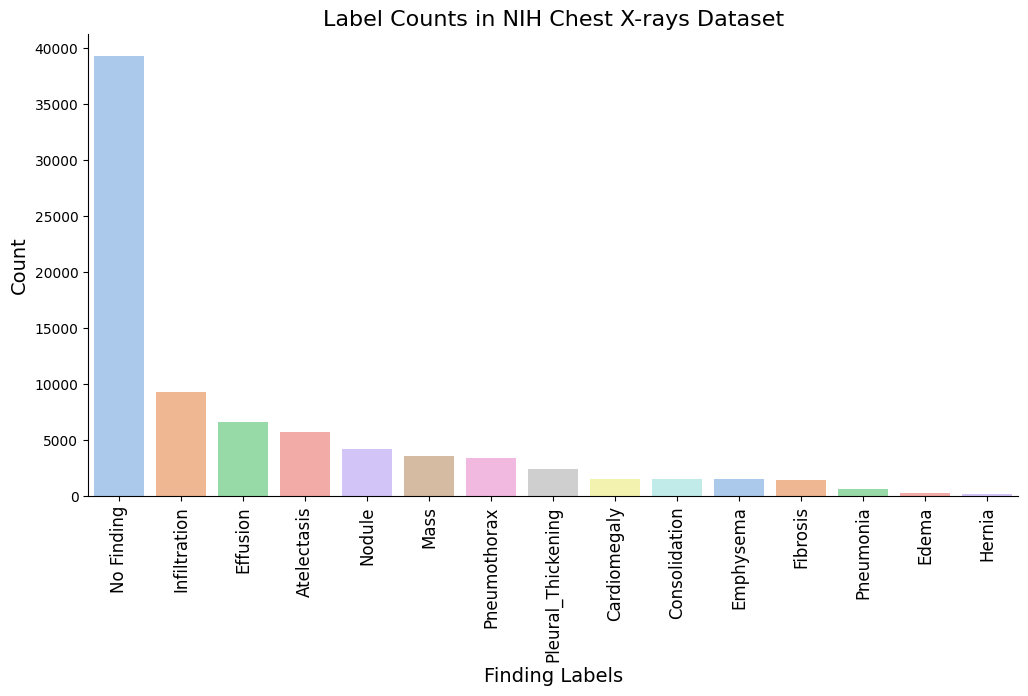

In [14]:
# Count occurrences of each label
label_counts = {label: sum(df['Finding Labels'].str.contains(label)) for label in all_labels}

# Convert to DataFrame for plotting
label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
label_counts_df = label_counts_df.sort_values(by='Count', ascending=False)

# Define a pastel color palette
palette = sns.color_palette("pastel", len(label_counts_df))

# Plot bar chart using pastel colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Label', y='Count', data=label_counts_df, palette=palette)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Finding Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Label Counts in NIH Chest X-rays Dataset', fontsize=16)

# Remove unnecessary borders
sns.despine()


In [15]:
display(label_counts_df)

,Label,Count
4,No Finding,39302
11,Infiltration,9353
6,Effusion,6589
2,Atelectasis,5728
8,Nodule,4177
14,Mass,3567
10,Pneumothorax,3407
13,Pleural_Thickening,2418
9,Cardiomegaly,1563
3,Consolidation,1521


<ipython-input-16-f52b0187c395>:23: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(


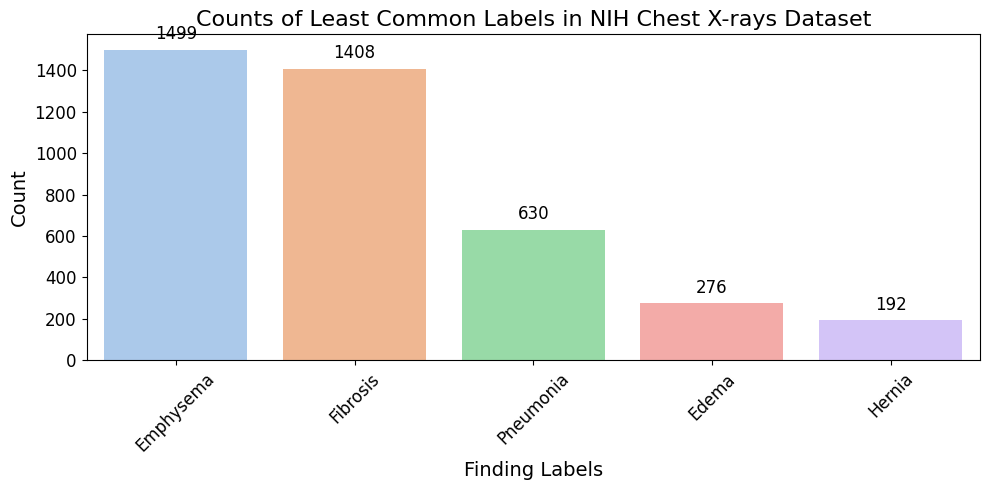

<Figure size 640x480 with 0 Axes>

Number of entries that contain at least one of the five least common labels: 3909


In [16]:
# Count occurrences of each label
label_counts = {label: sum(df['Finding Labels'].str.contains(label)) for label in all_labels}

# Convert to DataFrame and sort by count
label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
label_counts_df = label_counts_df.sort_values(by='Count', ascending=False)

# Extract the 5 least common labels
least_common_labels_df = label_counts_df.tail(5)

# Count occurrences for these labels in the dataset
least_common_entries = df[df['Finding Labels'].apply(lambda x: any(label in x for label in least_common_labels_df['Label']))]

# Count the occurrences of these specific labels in the dataset
least_common_label_counts = {label: sum(df['Finding Labels'].str.contains(label)) for label in least_common_labels_df['Label']}

# Convert to DataFrame
least_common_label_counts_df = pd.DataFrame(list(least_common_label_counts.items()), columns=['Label', 'Count'])
palette = sns.color_palette("pastel")

# Create a bar plot with a custom color scheme
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x='Label',
    y='Count',
    hue='Label',  # Assign hue to avoid warning
    data=least_common_label_counts_df,
    palette=palette,
    legend=False  # Remove unnecessary legend
)

# Add count labels above bars
for index, row in least_common_label_counts_df.iterrows():
    ax.text(index, row['Count'] + 50, str(row['Count']), color='black', ha="center", fontsize=12)

# Customize plot aesthetics
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Finding Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Counts of Least Common Labels in NIH Chest X-rays Dataset', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Remove top and right border for a cleaner look
sns.despine()

# Show the plot
plt.show()

# Display the number of entries that contain the least common labels
least_common_entries_count = least_common_entries.shape[0]
print(f"Number of entries that contain at least one of the five least common labels: {least_common_entries_count}")


## Notes

* The class with lowest number of entries contains 227 images. Since it will be hard to generate synthetic data, reducing all classes to 227 images to address class imbalance will significatly reduce available data.


We can consider the following strategies for addressing the class imbalances.

1. Data Augmentation (For Underrepresented Classes)

✅ Best for Image Data

To increase the number of images in underrepresented classes, we can apply data augmentation techniques such as:

  * Geometric Transformations: Rotation, flipping, cropping, translation, scaling.
  * Color Variations: Adjust brightness, contrast, saturation.
  * Noise Injection: Adding Gaussian noise or slight blur.
  * Generative Models: Use GANs (Generative Adversarial Networks) or Diffusion Models to synthesize realistic chest X-ray images.

2. Class Weighting in Model Training

✅ Best for Training Deep Learning Models

Instead of balancing data at the dataset level, we can adjust the model's loss function to give higher weight to underrepresented classes.

3. Oversampling the Minority Classes

✅ Best when Augmentation is not feasible

Instead of generating new synthetic data, we can duplicate existing samples in the underrepresented classes.

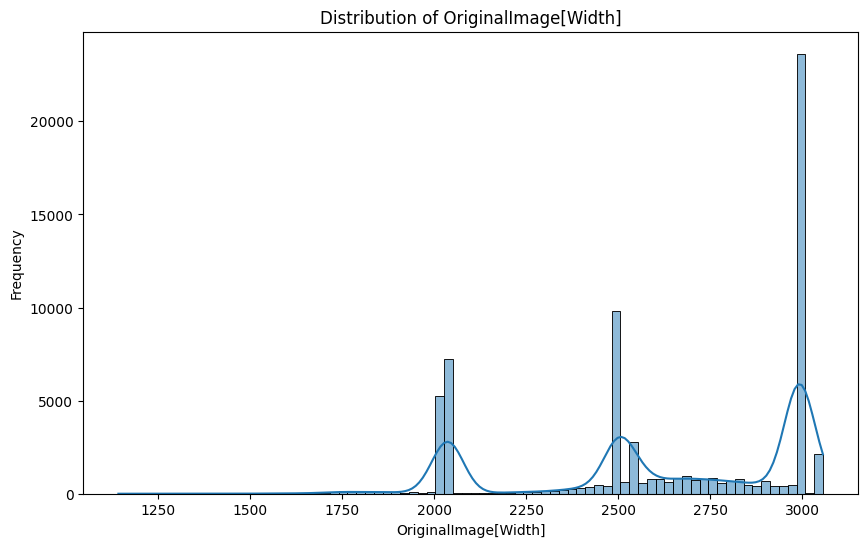

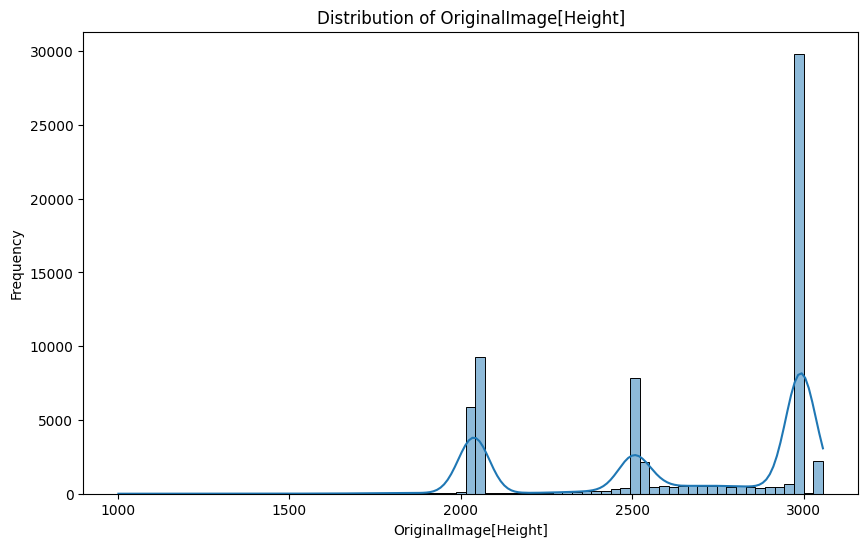

In [17]:
# Plot the distribution of OriginalImage[Width]
plt.figure(figsize=(10, 6))
sns.histplot(df['OriginalImage[Width'], kde=True)
plt.title('Distribution of OriginalImage[Width]')
plt.xlabel('OriginalImage[Width]')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of OriginalImage[Height]
plt.figure(figsize=(10, 6))
sns.histplot(df['Height]'], kde=True)
plt.title('Distribution of OriginalImage[Height]')
plt.xlabel('OriginalImage[Height]')
plt.ylabel('Frequency')
plt.show()

## Correlation Matrix

,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,has_Emphysema,has_Hernia,has_Atelectasis,has_Consolidation,has_No Finding,has_Pneumonia,has_Effusion,has_Edema,has_Nodule,has_Cardiomegaly,has_Pneumothorax,has_Infiltration,has_Fibrosis,has_Pleural_Thickening,has_Mass
0,0,1,58,M,PA,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,1,1,58,M,PA,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,2,1,58,M,PA,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,0,2,81,M,PA,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,0,3,81,F,PA,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


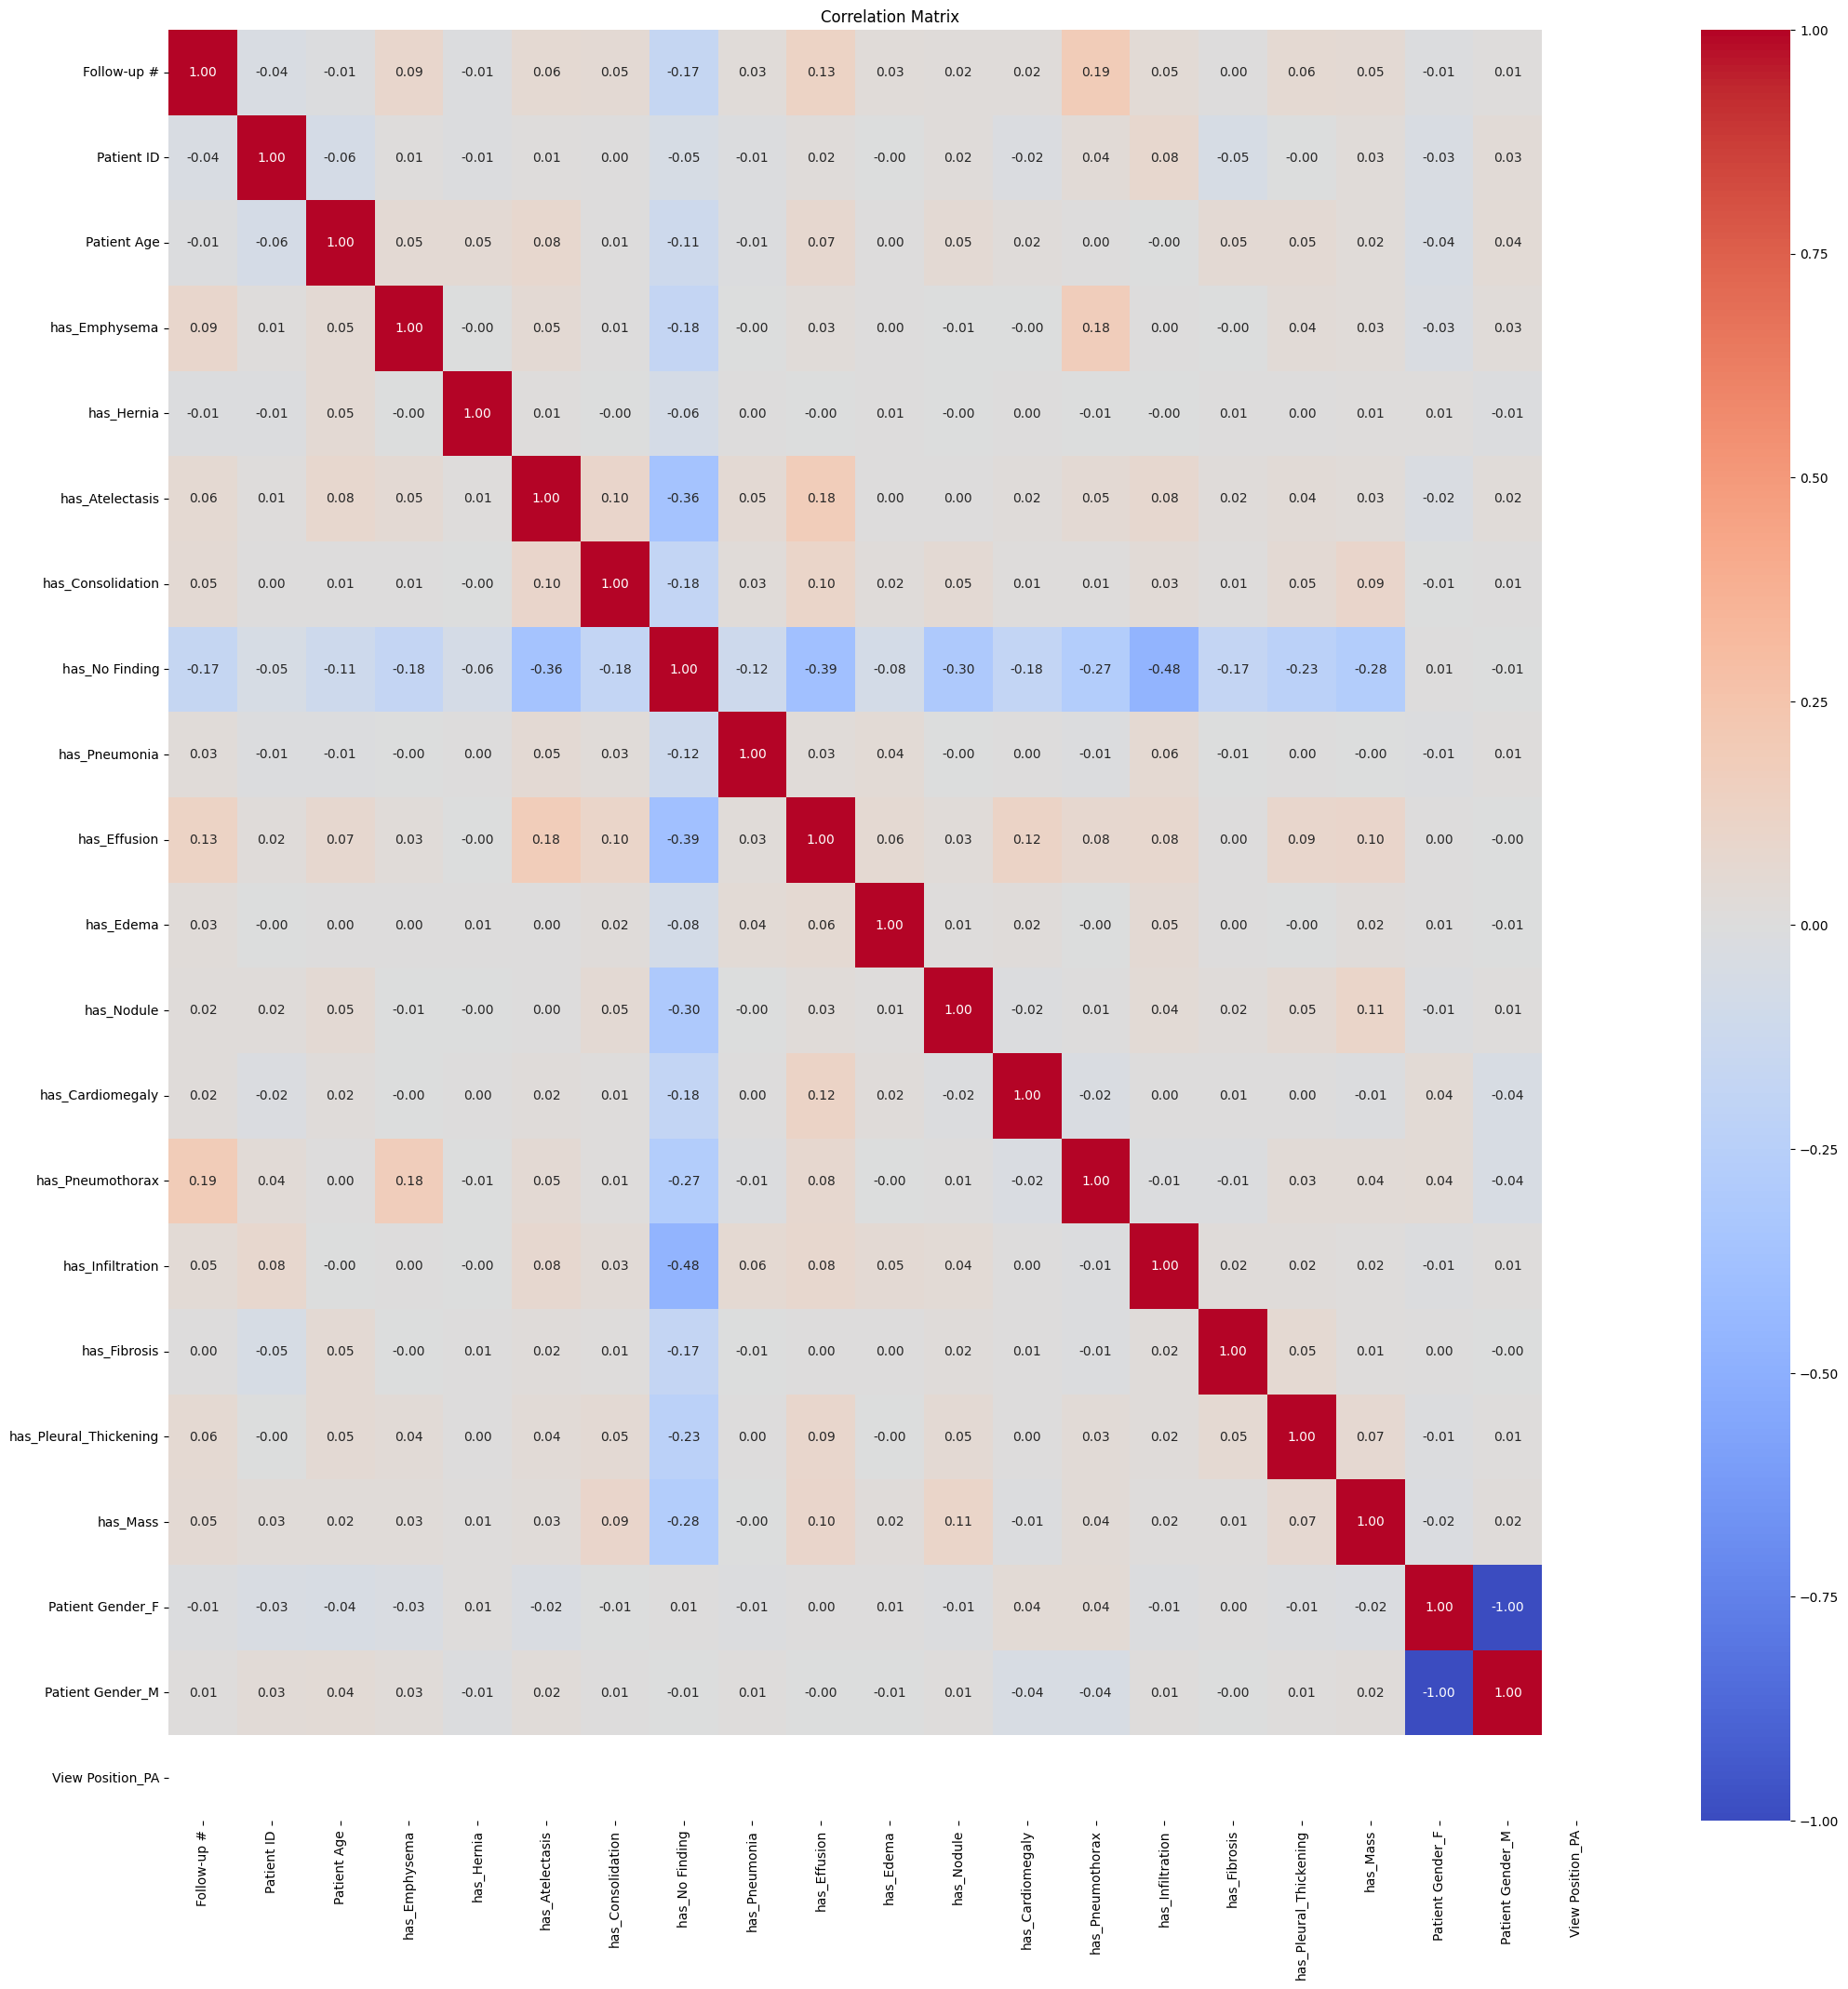

In [18]:

# Create a copy of the DataFrame to avoid modifying the original
df_processed = df.copy()

# Extract each label to a separate boolean column
for label in all_labels:
  df_processed[f'has_{label}'] = df_processed['Finding Labels'].str.contains(label)

# drop Finding Labels, Image Index, 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'
df_processed = df_processed.drop(columns=['Finding Labels', 'Image Index', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'])

display(df_processed.head())
# Encode categorical columns using one-hot encoding
categorical_columns = ['Patient Gender', 'View Position']
for column in categorical_columns:
  df_processed = pd.get_dummies(df_processed, columns=[column], prefix=[column])

# Encode the label for the boolean columns
for label in all_labels:
  df_processed[f'has_{label}'] = df_processed[f'has_{label}'].astype(int)


# Build the correlation matrix
correlation_matrix = df_processed.corr()


# Plot correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [19]:
display(correlation_matrix)

,Follow-up #,Patient ID,Patient Age,has_Emphysema,has_Hernia,has_Atelectasis,has_Consolidation,has_No Finding,has_Pneumonia,has_Effusion,...,has_Nodule,has_Cardiomegaly,has_Pneumothorax,has_Infiltration,has_Fibrosis,has_Pleural_Thickening,has_Mass,Patient Gender_F,Patient Gender_M,View Position_PA
Follow-up #,1.000000,-0.037928,-0.013289,0.092450,-0.009183,0.061499,0.047267,-0.166038,0.026362,0.129883,...,0.021563,0.018726,0.194457,0.045515,0.001235,0.058136,0.050655,-0.009111,0.009111,NaN
Patient ID,-0.037928,1.000000,-0.063590,0.010424,-0.013524,0.010825,0.003420,-0.051644,-0.009684,0.017826,...,0.018463,-0.019187,0.036095,0.083712,-0.049911,-0.002388,0.025359,-0.033435,0.033435,NaN
Patient Age,-0.013289,-0.063590,1.000000,0.050206,0.051530,0.081010,0.007709,-0.112697,-0.009968,0.074642,...,0.053755,0.015911,0.001583,-0.003880,0.050640,0.049888,0.024675,-0.044918,0.044918,NaN
has_Emphysema,0.092450,0.010424,0.050206,1.000000,-0.000521,0.047426,0.005506,-0.178780,-0.002123,0.030243,...,-0.007521,-0.003214,0.179638,0.004281,-0.002361,0.036329,0.027668,-0.030129,0.030129,NaN
has_Hernia,-0.009183,-0.013524,0.051530,-0.000521,1.000000,0.011642,-0.000635,-0.063357,0.003480,-0.000745,...,-0.004520,0.002851,-0.005996,-0.000547,0.007754,0.000154,0.014705,0.014536,-0.014536,NaN
has_Atelectasis,0.061499,0.010825,0.081010,0.047426,0.011642,1.000000,0.100876,-0.361277,0.049980,0.183345,...,0.003430,0.019088,0.049080,0.075590,0.021274,0.036974,0.027440,-0.024537,0.024537,NaN
has_Consolidation,0.047267,0.003420,0.007709,0.005506,-0.000635,0.100876,1.000000,-0.180117,0.029862,0.101630,...,0.052878,0.010409,0.011406,0.032557,0.013400,0.046928,0.093888,-0.006369,0.006369,NaN
has_No Finding,-0.166038,-0.051644,-0.112697,-0.178780,-0.063357,-0.361277,-0.180117,1.000000,-0.115143,-0.390217,...,-0.304698,-0.182645,-0.273522,-0.475871,-0.173148,-0.228665,-0.280222,0.005735,-0.005735,NaN
has_Pneumonia,0.026362,-0.009684,-0.009968,-0.002123,0.003480,0.049980,0.029862,-0.115143,1.000000,0.030284,...,-0.002619,0.002429,-0.008367,0.056407,-0.005583,0.001963,-0.002332,-0.008486,0.008486,NaN
has_Effusion,0.129883,0.017826,0.074642,0.030243,-0.000745,0.183345,0.101630,-0.390217,0.030284,1.000000,...,0.029035,0.123487,0.075600,0.082303,0.002156,0.091688,0.095923,0.004317,-0.004317,NaN


## Additional Charts and EDA

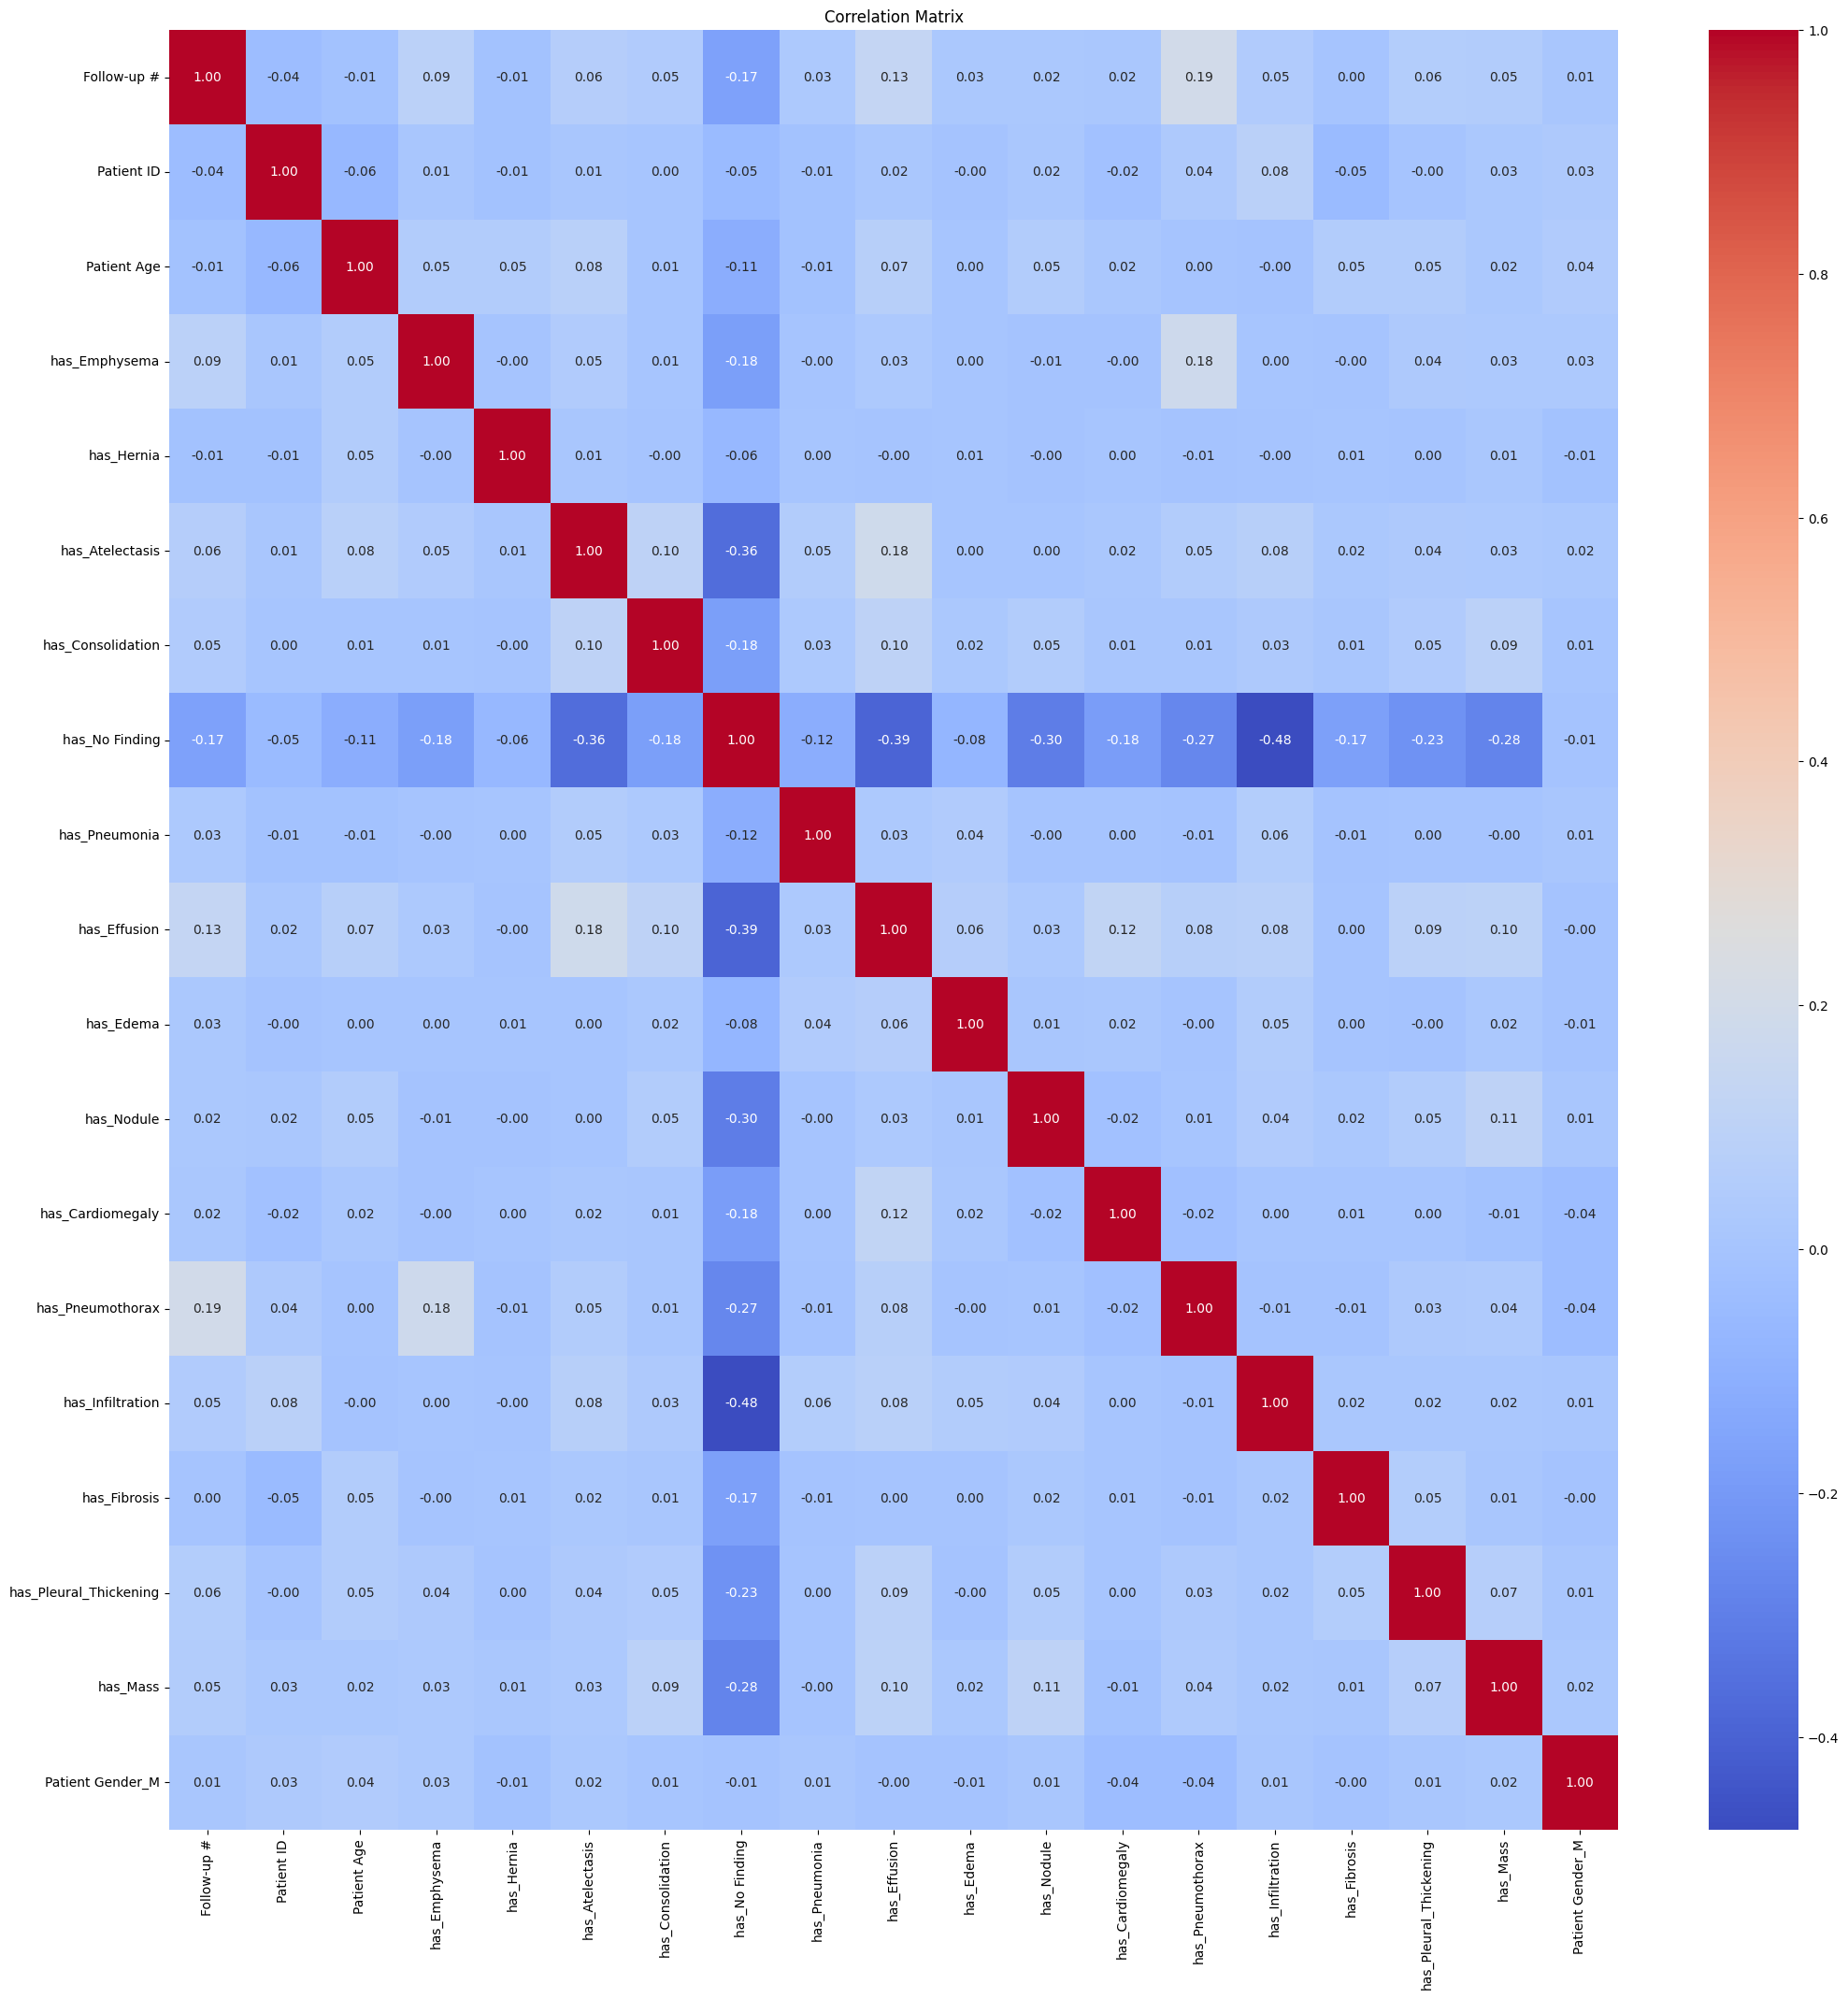

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of the DataFrame to avoid modifying the original
df_processed = df.copy()

# Extract each label to a separate boolean column
for label in all_labels:
    df_processed[f'has_{label}'] = df_processed['Finding Labels'].fillna('').str.contains(label, regex=False).astype(int)


# Drop unnecessary columns
drop_columns = ['Finding Labels', 'Image Index', 'OriginalImage[Width', 'Height]',
                'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
df_processed = df_processed.drop(columns=drop_columns, errors='ignore')

# Encode categorical columns using one-hot encoding, dropping first category to avoid redundancy
categorical_columns = ['Patient Gender', 'View Position']
df_processed = pd.get_dummies(df_processed, columns=categorical_columns, drop_first=True)

# Build the correlation matrix
correlation_matrix = df_processed.corr()

# Plot correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

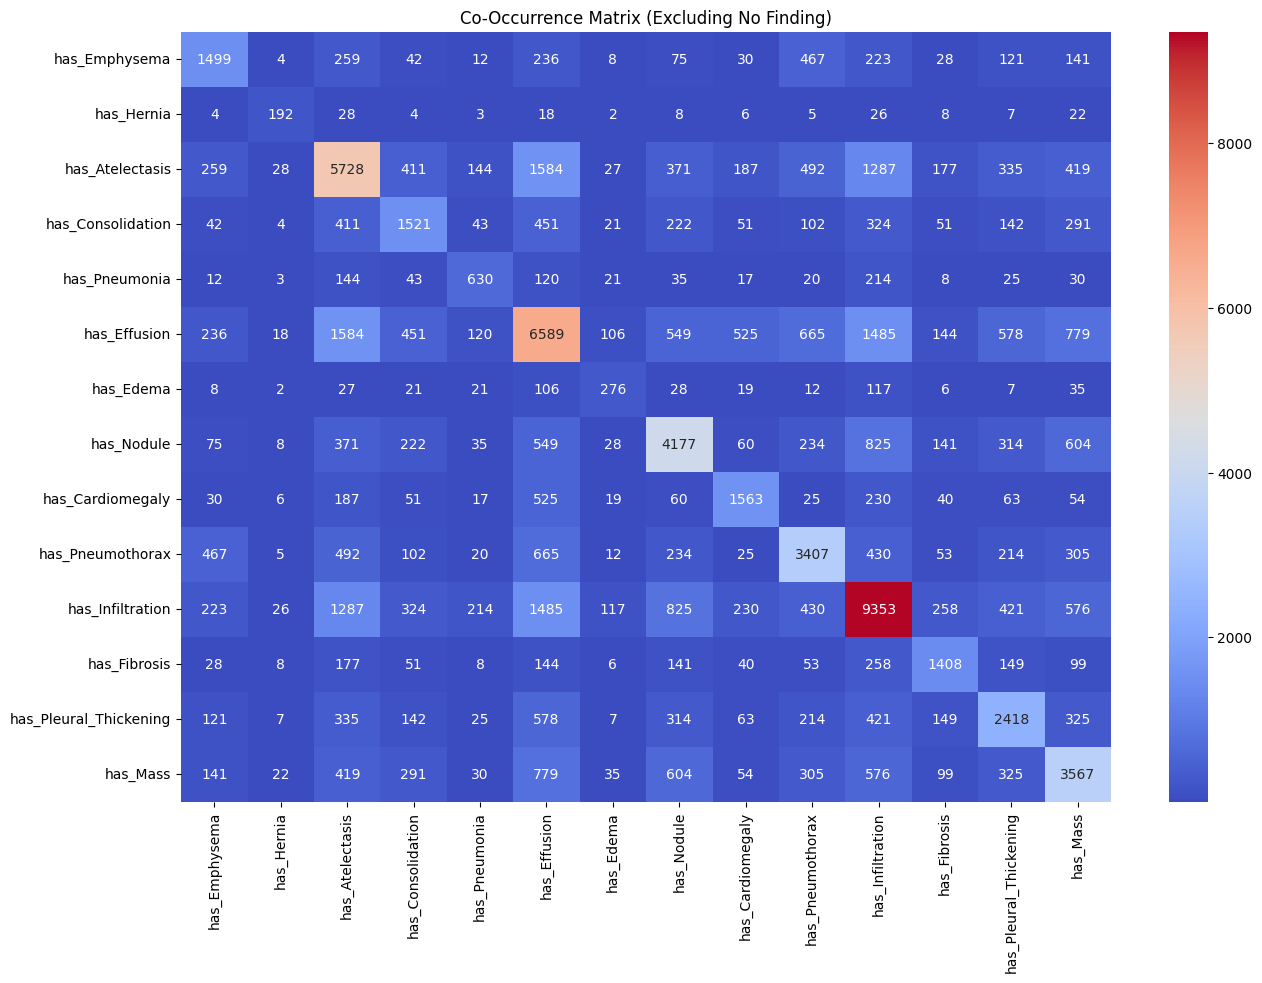

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract disease label columns, excluding 'No Finding'
disease_columns = [col for col in df_processed.columns if col.startswith('has_') and col != 'has_No Finding']

# Compute the co-occurrence matrix for the remaining disease labels
co_occurrence_matrix = np.dot(df_processed[disease_columns].T, df_processed[disease_columns])

# Convert to a DataFrame for easier visualization
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=disease_columns, columns=disease_columns)

# Plot the co-occurrence heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(co_occurrence_df, annot=True, fmt=".0f", cmap="coolwarm")
plt.title('Co-Occurrence Matrix (Excluding No Finding)')
plt.show()


### Preview Annotated Image

In [22]:
first_image = df_box_list.iloc[0]
image_info = df_box_list[df_box_list['Image Index'] == first_image['Image Index']]

display(image_info)

# Define image file name
image_name = first_image['Image Index']


# Determine the folder using dictionary lookup
image_folder = get_image_folder(df, image_name)
folder_number = int(image_folder.split("_")[1])

display(f"Image Name: {image_name}")
display(image_folder)
display(folder_number)

urllib.request.urlretrieve(links[folder_number - 1], f"{image_folder}.tar.gz")  # download the zip file

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN


'Image Name: 00013118_008.png'

'images_006'

6

('images_006.tar.gz', <http.client.HTTPMessage at 0x79ca483392d0>)

In [23]:
!tar -xvzf images_006.tar.gz

Streaming output truncated to the last 5000 lines.
images/00012609_007.png
images/00011804_007.png
images/00012776_004.png
images/00011632_004.png
images/00013352_007.png
images/00012864_005.png
images/00012692_002.png
images/00013335_000.png
images/00012019_007.png
images/00012530_000.png
images/00011683_049.png
images/00013762_001.png
images/00013594_039.png
images/00012238_014.png
images/00011624_001.png
images/00013260_002.png
images/00012266_002.png
images/00011587_013.png
images/00011778_000.png
images/00013615_021.png
images/00013508_004.png
images/00013424_002.png
images/00012573_010.png
images/00011959_007.png
images/00013685_050.png
images/00013670_097.png
images/00011579_010.png
images/00012346_000.png
images/00012857_003.png
images/00012685_000.png
images/00013111_107.png
images/00013261_003.png
images/00012095_000.png
images/00013499_004.png
images/00012355_004.png
images/00012183_001.png
images/00011810_008.png
images/00011705_000.png
images/00012937_001.png
images/000132

Index(['Image Index', 'Finding Label', 'x', 'y', 'w', 'h', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

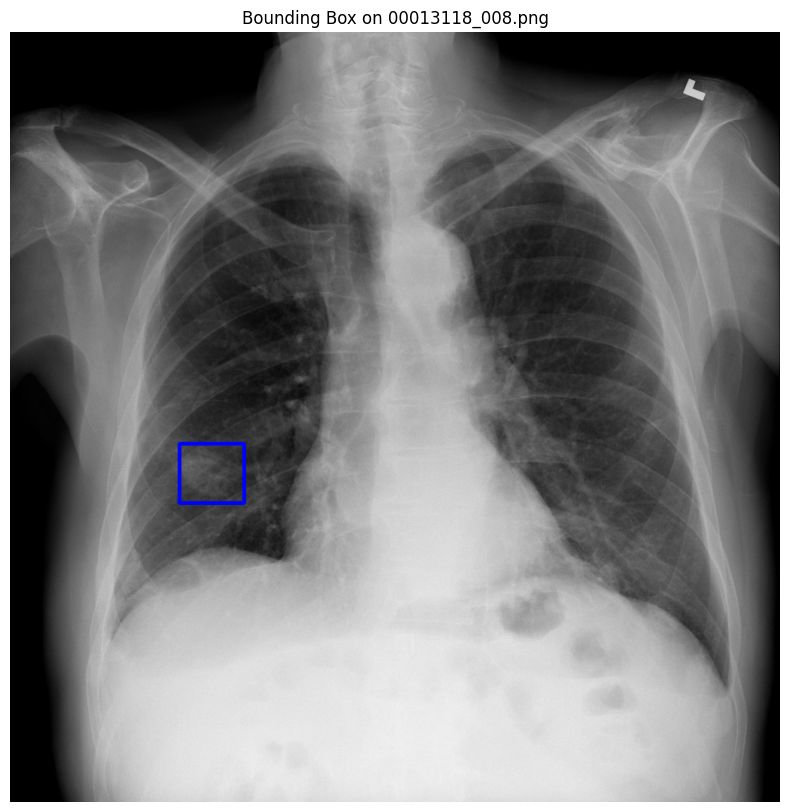

In [24]:
# Construct the image file path
image_file = f"images/{image_name}"

try:
  image = cv2.imread(image_file)
  if image is None:
      print(f"Error: Could not read image file '{image_file}'")
  else:
      image_info = df_box_list[df_box_list['Image Index'] == image_name]
      display(image_info.columns)

      # Extract bounding box values as integers
      x = int(image_info['x'].iloc[0])
      y = int(image_info['y'].iloc[0])
      w = int(image_info['w'].iloc[0])
      h = int(image_info['h'].iloc[0])

      # Draw the bounding box on the image
      cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)

      # Convert BGR to RGB for displaying
      plt.figure(figsize=(10, 10))
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      plt.title(f"Bounding Box on {image_name}")
      plt.axis("off")
      plt.show()
except Exception as e:
    print(f"An error occurred: {e}")
